<a href="https://colab.research.google.com/github/chiragsmagnani/InventoryOptimisation/blob/main/Inventory_Demand_Forecasting_2_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv("InventoryDemand.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


In [3]:
# Removing 'Unamed' column

data = data.drop(columns=['Unnamed: 0'])

In [5]:
# Visualizing the demand over time:

fig_demand = px.line(data, x='Date',
                     y='Demand',
                     title='Demand Over Time')
fig_demand.show()

Visualising inventory over time

In [6]:
fig_inventory = px.line(data, x='Date',
                        y='Inventory',
                        title='Inventory Over Time')
fig_inventory.show()

We can forecast the demand using SARIMA. Let’s first calculate the value of p and q using ACF and PACF plots:

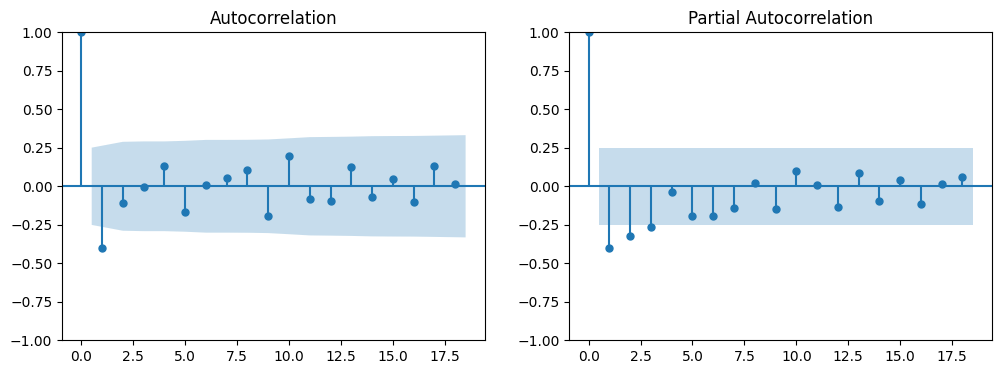

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
time_series = data.set_index('Date')['Demand']

differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()


Calculating **p**, **d**, and **q** for ARIMA, which includes checking for stationarity, applying differencing, and plotting the ACF and PACF:

ADF Statistic: -7.518718190638632
p-value: 3.8413100077967724e-11
Series is stationary.


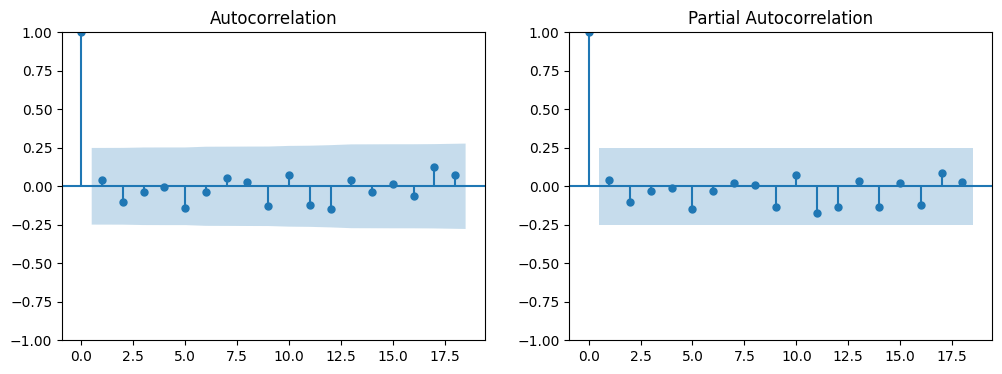

Selected parameters: p=1, d=0, q=1


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'data' is your DataFrame and 'Date' is already converted to datetime
time_series = data.set_index('Date')['Demand']

# Step 1: Check stationarity using ADF test
result = adfuller(time_series)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value is greater than 0.05, series is non-stationary, apply differencing
d = 0
if result[1] > 0.05:
    print("Series is non-stationary. Differencing...")
    time_series = time_series.diff().dropna()
    d = 1
else:
    print("Series is stationary.")

# Step 2: Plot ACF and PACF for differenced series (if differencing was applied)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(time_series, ax=axes[0])
plot_pacf(time_series, ax=axes[1])
plt.show()

# Step 3: Automatically select p and q based on ACF and PACF
p = 1  # Based on the PACF plot (usually the lag at which the plot cuts off)
q = 1  # Based on the ACF plot (usually the lag at which the plot cuts off)

# Print p, d, q values
print(f'Selected parameters: p={p}, d={d}, q={q}')

In [19]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2) #2 because the data contains a time period of 2 months only
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int64


# **Inventory Optimization:**
Now let’s see how we can optimize inventory according to the forecasted demand for the next ten days:

In [20]:
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory)
lead_time = 1 # it's different for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it's different for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it's different for every business, 0.1 is an example
stockout_cost = 10  # # it's different for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total Cost: 561.8000000000001


**Optimal Order Quantity: 236** : The optimal order quantity refers to the quantity of a product that should be ordered from suppliers when the inventory level reaches a certain point. In this case, an optimal order quantity of 236 units has been calculated.

**Reorder Point: 235.25** : The reorder point is the inventory level at which a new order should be placed to replenish stock before it runs out. In this case, a reorder point of 235.25 units has been calculated, which means that when the inventory reaches or falls below this level, an order should be placed to replenish stock.

**Safety Stock: 114.45**: Safety stock is the additional inventory kept on hand to account for uncertainties in demand and supply. It acts as a buffer against unexpected variations in demand or lead time. In this case, a safety stock of 114.45 units has been calculated, which helps ensure that there’s enough inventory to cover potential fluctuations in demand or lead time.

**Total Cost: 561.80**: The total cost represents the combined costs associated with inventory management. In this case, the total cost has been calculated as approximately 561.80 units based on the order quantity, reorder point, safety stock, and associated costs.

## **By analyzing these values, you can make informed decisions about how much inventory to order and when to place orders to ensure a smooth supply chain and customer satisfaction while minimizing costs.**